In [1]:
import numpy as np

In [2]:
# Parâmetros do labirinto
rows, cols = 5, 5
goal = (4, 4)
walls = [(1, 1), (2, 1), (3, 1), (3, 2)]  # Paredes no labirinto

# Ações: cima, baixo, esquerda, direita
actions = ['up', 'down', 'left', 'right']
action_idx = {a: i for i, a in enumerate(actions)}

# Q-table: estados (25) x ações (4)
q_table = np.zeros((rows * cols, len(actions)))

# Hiperparâmetros
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

In [3]:
# Funções de apoio
def state_to_index(state):
    return state[0] * cols + state[1]

def valid_move(pos):
    r, c = pos
    return 0 <= r < rows and 0 <= c < cols and (r, c) not in walls

def step(state, action):
    r, c = state
    if action == 'up':
        next_state = (r - 1, c)
    elif action == 'down':
        next_state = (r + 1, c)
    elif action == 'left':
        next_state = (r, c - 1)
    elif action == 'right':
        next_state = (r, c + 1)

    if not valid_move(next_state):
        next_state = state  # Fica parado se bater na parede

    reward = 1 if next_state == goal else 0
    done = next_state == goal
    return next_state, reward, done

In [4]:
# Treinamento
for ep in range(episodes):
    state = (0, 0)
    done = False

    while not done:
        s_idx = state_to_index(state)

        # Epsilon-greedy
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = actions[np.argmax(q_table[s_idx])]

        next_state, reward, done = step(state, action)
        ns_idx = state_to_index(next_state)

        q_table[s_idx, action_idx[action]] += alpha * (
            reward + gamma * np.max(q_table[ns_idx]) - q_table[s_idx, action_idx[action]]
        )

        state = next_state

In [5]:
# Teste: seguir a política aprendida
state = (0, 0)
path = [state]
while state != goal:
    s_idx = state_to_index(state)
    action = actions[np.argmax(q_table[s_idx])]
    state, _, _ = step(state, action)
    path.append(state)

# Exibir o caminho aprendido
print("Caminho aprendido pelo agente:")
maze = np.full((rows, cols), ' ')
for (r, c) in walls:
    maze[r, c] = '#'
for (r, c) in path:
    maze[r, c] = '.'
maze[0, 0] = 'S'
maze[goal[0], goal[1]] = 'G'
for row in maze:
    print(' '.join(row))


Caminho aprendido pelo agente:
S . . . .
  #     .
  #     .
  # #   .
        G


/tmp/ipykernel_80349/494927463.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys', 4)


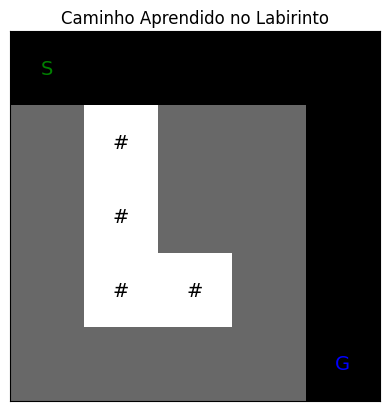

In [7]:
import matplotlib.pyplot as plt

# === GRÁFICO ===

# Cria uma matriz do labirinto para visualização
maze = np.zeros((rows, cols))
for (r, c) in walls:
    maze[r, c] = -1  # parede
for (r, c) in path:
    maze[r, c] = 0.5  # caminho
maze[0, 0] = 0.7  # início
maze[goal[0], goal[1]] = 1  # objetivo

# Plota o labirinto
fig, ax = plt.subplots()
cmap = plt.cm.get_cmap('Greys', 4)
im = ax.imshow(maze, cmap=cmap, vmin=-1, vmax=1)

# Anotações
for r in range(rows):
    for c in range(cols):
        if (r, c) in walls:
            ax.text(c, r, '#', ha='center', va='center', color='black', fontsize=14)
        elif (r, c) == (0, 0):
            ax.text(c, r, 'S', ha='center', va='center', color='green', fontsize=14)
        elif (r, c) == goal:
            ax.text(c, r, 'G', ha='center', va='center', color='blue', fontsize=14)
        elif (r, c) in path:
            ax.text(c, r, '.', ha='center', va='center', color='black', fontsize=14)

ax.set_title('Caminho Aprendido no Labirinto')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Simulação de ambiente: duas ações (máquinas) com probabilidades diferentes de vitória
def bandit_environment(action):
    if action == 0:
        return np.random.rand() < 0.3  # Máquina 0 dá recompensa 30% das vezes
    elif action == 1:
        return np.random.rand() < 0.7  # Máquina 1 dá 70% das vezes

# Dados para treino
X = []
y = []

# Treinamento usando um modelo supervisionado
model = LogisticRegression()

for i in range(200):
    # Epsilon-greedy: explora ou usa modelo
    if i < 10 or np.random.rand() < 0.1 or len(y) < 10:
        action = np.random.choice([0, 1])  # Explora no começo
    else:
        preds = model.predict_proba([[0], [1]])[:, 1]  # Probabilidade de recompensa
        action = np.argmax(preds)

    # Recebe a recompensa
    reward = bandit_environment(action)

    # Armazena o par (ação, recompensa)
    X.append([action])
    y.append(reward)

    # Atualiza o modelo
    if len(set(y)) > 1:  # Evita erro se só tiver 0s ou 1s
        model.fit(X, y)

# Teste: qual máquina o modelo aprendeu a preferir?
preds = model.predict_proba([[0], [1]])[:, 1]
print(f"Probabilidades estimadas de recompensa: Máquina 0 = {preds[0]:.2f}, Máquina 1 = {preds[1]:.2f}")
print(f"Melhor escolha: Máquina {np.argmax(preds)}")


Probabilidades estimadas de recompensa: Máquina 0 = 0.17, Máquina 1 = 0.72
Melhor escolha: Máquina 1


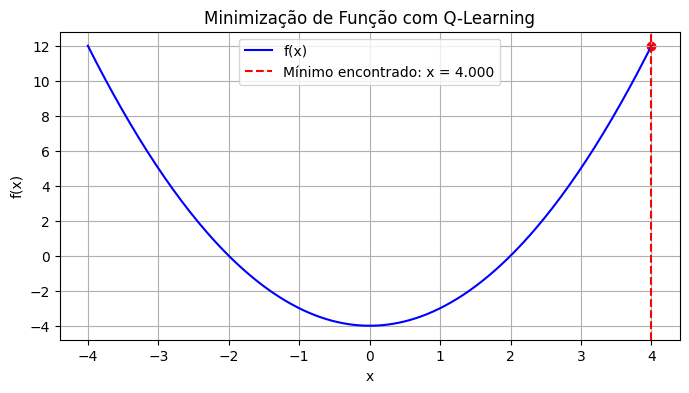

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Função objetivo: queremos minimizar isso
def f(x):
    return x**2 -  4

# Espaço de estados e ações
x_min, x_max = -4, 4
n_states = 100
states = np.linspace(x_min, x_max, n_states)
delta = 0.1  # tamanho do passo

# Ações: 0 = esquerda, 1 = direita
actions = [0, 1]

# Q-table: estados x ações
q_table = np.zeros((n_states, len(actions)))

# Hiperparâmetros
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 1000

# Funções auxiliares
def get_state_index(x):
    return np.clip(int((x - x_min) / (x_max - x_min) * n_states), 0, n_states - 1)

# Treinamento
for ep in range(episodes):
    x = np.random.uniform(x_min, x_max)  # estado inicial aleatório

    for _ in range(50):  # limite de passos por episódio
        s_idx = get_state_index(x)

        # Política epsilon-greedy
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table[s_idx])

        # Executa ação
        x_new = x - delta if action == 0 else x + delta
        x_new = np.clip(x_new, x_min, x_max)

        # Calcula recompensa negativa da função
        reward = -f(x_new)

        # Atualiza Q-table
        ns_idx = get_state_index(x_new)
        q_table[s_idx, action] += alpha * (
            reward + gamma * np.max(q_table[ns_idx]) - q_table[s_idx, action]
        )

        x = x_new

# Após treinamento, encontra o melhor estado
values = -np.array([np.max(q_table[i]) for i in range(n_states)])
best_idx = np.argmax(values)
best_x = states[best_idx]

# Plot da função e do mínimo encontrado
x_plot = np.linspace(x_min, x_max, 200)
y_plot = f(x_plot)

plt.figure(figsize=(8, 4))
plt.plot(x_plot, y_plot, label='f(x)', color='blue')
plt.axvline(best_x, color='red', linestyle='--', label=f'Mínimo encontrado: x = {best_x:.3f}')
plt.scatter([best_x], [f(best_x)], color='red')
plt.title('Minimização de Função com Q-Learning')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()